# Mole detection

In [1]:
import os

from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout,Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16, mobilenet_v2

from cv2 import bilateralFilter

If yourun this notebook from Google Colab, make sure to have the correct labeled dataset at the root of your Google Drive

In [2]:
try:
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [4]:
if IN_COLAB:
    drive.mount('/content/drive/')
    base_path = '/content/drive/MyDrive'
else:
    base_path = '.'

In [5]:
# paths definition
dataset_path = os.path.join(base_path, 'labeled_dataset')
train_path = os.path.join(dataset_path, 'train')
valid_path = os.path.join(dataset_path, 'valid')
test_path = os.path.join(dataset_path, 'test')

In [6]:
# model constants definition
CLASSES = ['malignant', 'benign']
INPUT_SIZE = (224, 224)
# INPUT_SIZE = (387, 632)
INPUT_SHAPE = INPUT_SIZE + (3,)
BATCH_SIZE = 32
EPOCHS = 20

In [7]:
D = 9
SIGMACOLOR = 75
SIGMASPACE = 75 #sigmaSpace[, borderType]]

def preprocess_image(image, vgg16=True, bilateral=True):
  #making image clearer. Is it really better for the CNN ? 
  #img_adp= exposure.equalize_adapthist(img, clip_limit=0.03)
  #inverting to bgr  
  #img_bgr = img_adp[..., ::-1]
  #The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling. Returning float.
  if vgg16:
    image = vgg16.preprocess_input(image, data_format=None)
  #applying bilateral filtering returning float
  if bilateral:
    image = bilateralFilter(image, d=D, sigmaColor=SIGMACOLOR, sigmaSpace=SIGMASPACE)
  #converting float to integer uint8 (not needed)
  #image = image.astype(uint8)
  return image


In [8]:
train_batches = ImageDataGenerator(
    preprocessing_function=vgg16.preprocess_input).flow_from_directory(
        train_path, 
        target_size=INPUT_SIZE, 
        classes=CLASSES, 
        shuffle = True,
        batch_size=BATCH_SIZE)
valid_batches = ImageDataGenerator(
    preprocessing_function=vgg16.preprocess_input).flow_from_directory(
        valid_path, 
        target_size=INPUT_SIZE, 
        classes=CLASSES, 
        shuffle = True,
        batch_size=BATCH_SIZE)
test_batches = ImageDataGenerator(
    preprocessing_function=vgg16.preprocess_input).flow_from_directory(
        test_path, 
        target_size=INPUT_SIZE, 
        classes=CLASSES, 
        shuffle = False,
        batch_size=BATCH_SIZE)

Found 2177 images belonging to 2 classes.
Found 434 images belonging to 2 classes.
Found 289 images belonging to 2 classes.


In [9]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')



In [10]:
class_dict = train_batches.class_indices
imgs, labels = next(train_batches)
titles = ['benign' if x[class_dict['benign']]==1 else 'malignant' for x in labels]
plots(imgs, figsize=(36,18), titles=titles, rows=4)

AttributeError: 'bool' object has no attribute 'preprocess_input'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


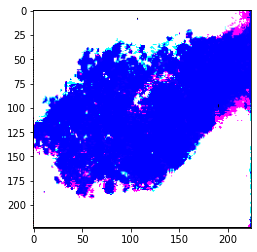

In [39]:
# imgs[0]
# plt.imshow(imgs[0])

In [12]:
model = Sequential()
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
model.add(base_model)
model.layers[0].summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 21,137,986
Trainable params: 21,137,986
Non-trainable params: 0
_________________________________________________________________


In [14]:
for layers in model.layers[0].layers: # looping over each layers in layer 0 to freeze them
  layers.trainable = False

model.layers[0].trainable = False

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 21,137,986
Trainable params: 6,423,298
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.fit(train_batches, 
          steps_per_epoch=len(train_batches.filenames)//BATCH_SIZE, 
          epochs=EPOCHS, 
          validation_data=valid_batches, 
          validation_steps=len(test_batches.filenames)//BATCH_SIZE
          )
          

Epoch 1/20
68/68 [==============================] - 68s 609ms/step - loss: 7.0968 - accuracy: 0.6905 - val_loss: 0.4239 - val_accuracy: 0.8299
Epoch 2/20
68/68 [==============================] - 35s 509ms/step - loss: 0.3728 - accuracy: 0.8368 - val_loss: 0.4158 - val_accuracy: 0.8299
Epoch 3/20
68/68 [==============================] - 35s 512ms/step - loss: 0.2853 - accuracy: 0.8740 - val_loss: 0.3701 - val_accuracy: 0.8229
Epoch 4/20
68/68 [==============================] - 35s 510ms/step - loss: 0.2092 - accuracy: 0.9122 - val_loss: 0.4438 - val_accuracy: 0.8264
Epoch 5/20
68/68 [==============================] - 36s 525ms/step - loss: 0.1763 - accuracy: 0.9325 - val_loss: 0.4979 - val_accuracy: 0.8056
Epoch 6/20
68/68 [==============================] - 36s 524ms/step - loss: 0.2413 - accuracy: 0.8759 - val_loss: 0.4633 - val_accuracy: 0.8229
Epoch 7/20
68/68 [==============================] - 36s 536ms/step - loss: 0.1421 - accuracy: 0.9410 - val_loss: 0.5321 - val_accuracy: 0.8403

In [18]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

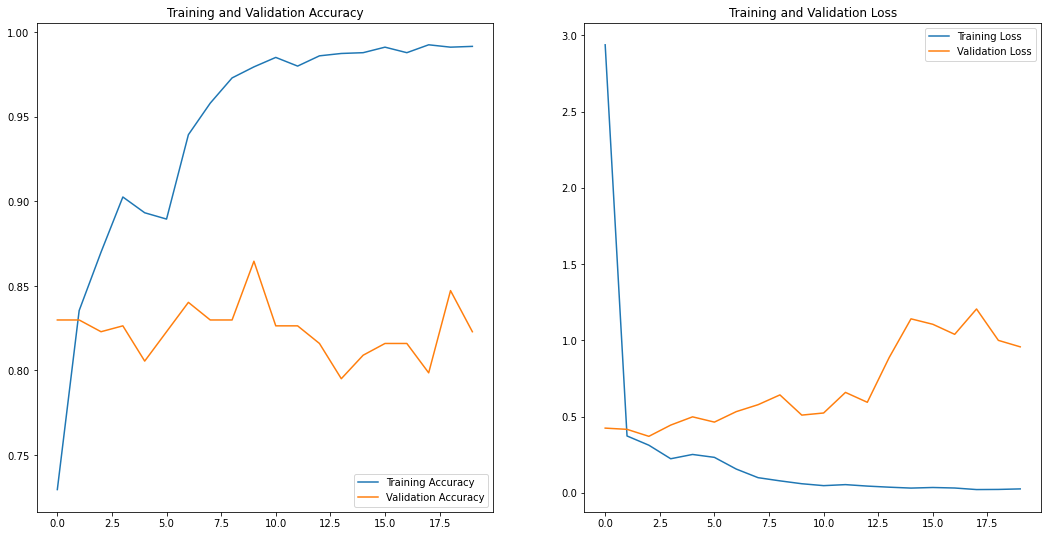

In [19]:
epochs_range = range(EPOCHS)

plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [9]:
train_batches = ImageDataGenerator(
    preprocessing_function=mobilenet_v2.preprocess_input).flow_from_directory(
        train_path, 
        target_size=INPUT_SIZE, 
        classes=CLASSES, 
        shuffle = True,
        batch_size=BATCH_SIZE)
valid_batches = ImageDataGenerator(
    preprocessing_function=mobilenet_v2.preprocess_input).flow_from_directory(
        valid_path, 
        target_size=INPUT_SIZE, 
        classes=CLASSES,
        shuffle = True,
        batch_size=BATCH_SIZE)
test_batches = ImageDataGenerator(
    preprocessing_function=mobilenet_v2.preprocess_input).flow_from_directory(
        test_path, 
        target_size=INPUT_SIZE, 
        classes=CLASSES, 
        shuffle = False,
        batch_size=BATCH_SIZE)

Found 2177 images belonging to 2 classes.
Found 434 images belonging to 2 classes.
Found 289 images belonging to 2 classes.


In [10]:
model = Sequential()
base_model = mobilenet_v2.MobileNetV2(weights='imagenet',include_top=False, input_shape=INPUT_SHAPE)
model.add(base_model)
model.layers[0].summary()

_relu[0][0]        
__________________________________________________________________________________________________
block_6_depthwise (DepthwiseCon (None, 14, 14, 192)  1728        block_6_pad[0][0]                
__________________________________________________________________________________________________
block_6_depthwise_BN (BatchNorm (None, 14, 14, 192)  768         block_6_depthwise[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 14, 14, 192)  0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 14, 14, 64)   12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 14, 14, 64)   256         block_6_project[0][0]   

In [11]:
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               16056576  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 18,315,074
Trainable params: 18,280,962
Non-trainable params: 34,112
_________________________________________________________________


In [12]:
for layers in model.layers[0].layers: # looping over each layers in layer 0 to freeze them
  layers.trainable = False

model.layers[0].trainable = False

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               16056576  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 18,315,074
Trainable params: 16,057,090
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.fit(train_batches, 
          steps_per_epoch=len(train_batches.filenames)//BATCH_SIZE, 
          epochs=EPOCHS*2, 
          validation_data=valid_batches, 
          validation_steps=len(test_batches.filenames)//BATCH_SIZE
          )

Epoch 1/40
68/68 [==============================] - 41s 400ms/step - loss: 7.2841 - accuracy: 0.7125 - val_loss: 0.4708 - val_accuracy: 0.7917
Epoch 2/40
68/68 [==============================] - 14s 205ms/step - loss: 0.4405 - accuracy: 0.7875 - val_loss: 0.4286 - val_accuracy: 0.7986
Epoch 3/40
68/68 [==============================] - 14s 205ms/step - loss: 0.3627 - accuracy: 0.8221 - val_loss: 0.3881 - val_accuracy: 0.7778
Epoch 4/40
68/68 [==============================] - 14s 205ms/step - loss: 0.3452 - accuracy: 0.8151 - val_loss: 0.4009 - val_accuracy: 0.8090
Epoch 5/40
68/68 [==============================] - 14s 204ms/step - loss: 0.2884 - accuracy: 0.8632 - val_loss: 0.4304 - val_accuracy: 0.7986
Epoch 6/40
68/68 [==============================] - 14s 204ms/step - loss: 0.2727 - accuracy: 0.8755 - val_loss: 0.4433 - val_accuracy: 0.8194
Epoch 7/40
68/68 [==============================] - 14s 205ms/step - loss: 0.2175 - accuracy: 0.9187 - val_loss: 0.4920 - val_accuracy: 0.8090

In [16]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

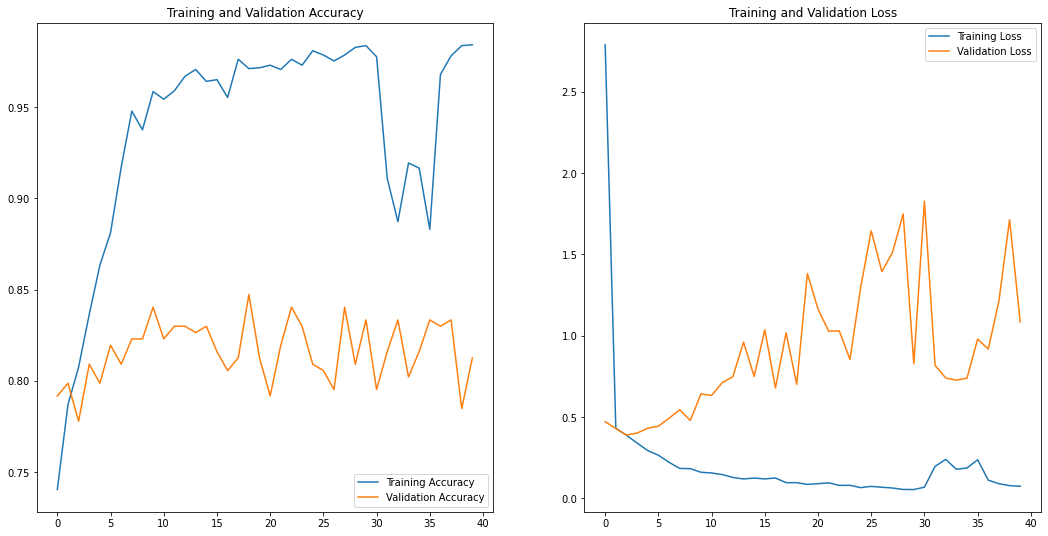

In [18]:
epochs_range = range(EPOCHS*2)

plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
model.save('temp_model.h5')